## Tutorial on Generative Inverse Heat Dissipation (ICLR 2023)

Official github repository [here](https://github.com/AaltoML/generative-inverse-heat-dissipation).

In this tutorial notebook, we'll investigate conditional generation properties of the Inverse Heat Dissipation Model (IHDM) for the MNIST dataset. Originally, the authors only performed unconditional generation experiments with different image datasets, where the deblurring process started from a flat image
with a certain average gray value. Here, we'll observe how a simple class-conditioning embedding can guide the UNet's output to a specific class. This extension enhances the model's intra-class generation variance as the generation landscape becomes more constricted than before (eg., the model is implicitly guided
to generate the digit 1 over any other digit).

But, first, we begin with an introduction to the 1D and 2D heat equations and how it changes an input signal over time. Then, we'll see how observation noise on top of this deterministic heat equation makes inversion of the heat equation a feasible problem (Algorithm 1 of the paper).
Finally, we'll end with some sample generation results for the MNIST and CIFAR10 datasets. 

Optionally, we can also train the model from scratch and observe the training process. But, we provide the pre-trained weights for both CIFAR10 and MNIST, so you can skip the training process and directly observe the generation results.

You can download weights for the class-conditoned models for both datasets [here](https://nextcloud.mpi-klsb.mpg.de/index.php/s/yAK9Z9kfn8T8fZy).

Place them inside ```runs/{dataset}/conditional/checkpoints-meta/``` where ```dataset={mnist, cifar10}```.

In [1]:
import os
from os.path import join as pjoin
from pathlib import Path

import numpy as np
import torch
import wandb
import matplotlib.pyplot as plt
from IPython.display import HTML, Image
from matplotlib.animation import FuncAnimation
from einops import repeat
from omegaconf import OmegaConf

%load_ext autoreload
%autoreload 2

from scripts import utils

config_mnist = OmegaConf.load("configs/mnist_cond.yaml")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# For reproducibility
utils.safe_state(config_mnist.seed, device)

blur_sigma_max = config_mnist.model.blur_sigma_max
blur_sigma_min = config_mnist.model.blur_sigma_min
blur_schedule = np.exp(np.linspace(np.log(blur_sigma_min), np.log(blur_sigma_max), config_mnist.model.K))
blur_schedule = np.array([0] + list(blur_schedule))  # Add the k=0 timestep

### Illustration of 1D heat equation

$$
\frac{\partial T}{\partial t} = \alpha \left( \frac{\partial^2 T}{\partial x^2} \right)
$$

where $T$ is the temperature, $t$ is time, $x$ is the position, and $\alpha$ is the thermal diffusivity.

$$
T(x,t) = \sum_{n=0}^{\infty} B_n \cos \left( \frac{n \pi x}{L} \right) \exp \left( -\alpha \left( \frac{n \pi}{L} \right)^2 t \right)
$$

where $B_n$ are the Fourier coefficients and $L$ is the length of the rod. In the matrix exponential form, the solution can be written as:

$$
T(\mathbf{x}, t) = \exp(\mathbf{V} \Lambda \mathbf{V}^T t) T_0
$$

where $\mathbf{V}$ is the matrix of eigenvectors of the laplacian operator, $\Lambda$ is the diagonal matrix of eigenvalues of the laplacian operator, and $T_0$ is the initial temperature distribution. The above equation can be further simplified to:

$$
\begin{align*}
T(\mathbf{x}, t) &= \mathbf{V} \exp(\Lambda t) \mathbf{V}^T T_0 \\
\mathbf{V}^T T(\mathbf{x}, t) &= \mathbf{V}^T \mathbf{V} \exp(\Lambda t) \mathbf{V}^T T_0 \\
\tilde{T}(\mathbf{x}, t) &= \exp(\Lambda t) \tilde{T}_0 \\
T(\mathbf{x}, t) &= \mathbf{V} \tilde{T}(\mathbf{x}, t)
\end{align*}
$$

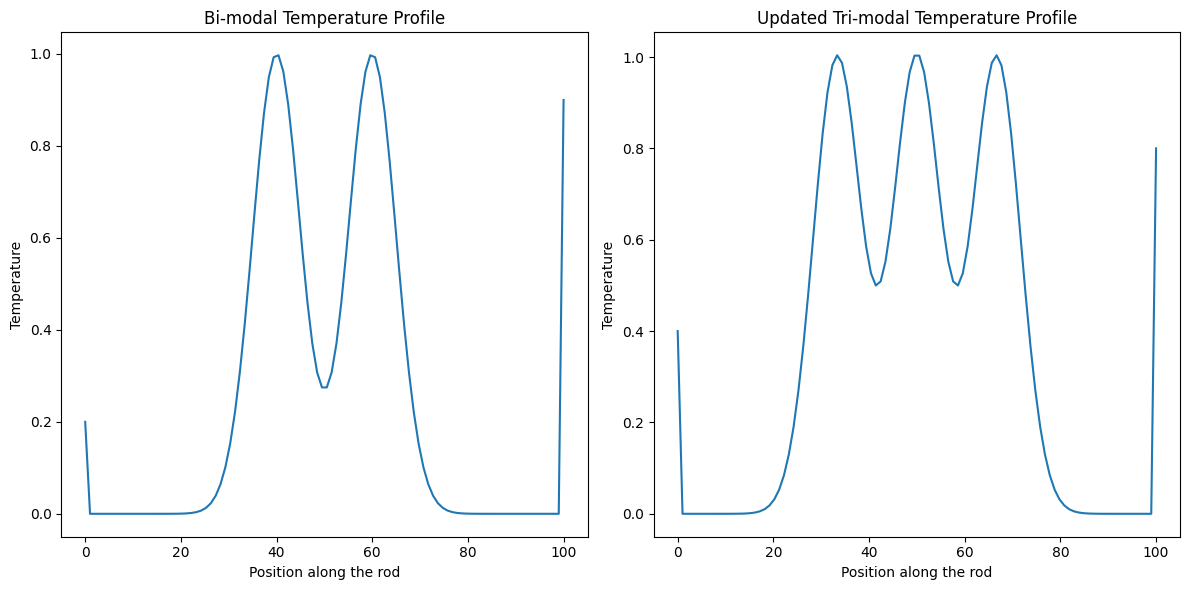

In [2]:
# Defining intial temperature profile of a rod of length L - a bi-modal or tri-modal distribution

def gaussian(x, mean, std, amplitude=1):
    return amplitude * torch.exp(-((x - mean) ** 2) / (2 * std ** 2))

# Length of the rod
L = 100
x = torch.linspace(0, L, steps=L).to(device)

# Bi-modal temperature distribution
# Two Gaussians with means slightly off the center
mean1 = L / 2 - L / 10
mean2 = L / 2 + L / 10
std = L / 20  # Standard deviation
bi_modal_temp = gaussian(x, mean1, std) + gaussian(x, mean2, std)

# Tri-modal temperature distribution with more spacing
# Two Gaussians symmetrically around the center and one at the center
mean1_tri = L / 2 - L / 6  # First peak moved further left
mean2_tri = L / 2 + L / 6  # Second peak moved further right
mean3 = L / 2  # Center peak
std_tri = L / 20  # Standard deviation
tri_modal_temp_spaced = gaussian(x, mean1_tri, std_tri) + gaussian(x, mean2_tri, std_tri) + gaussian(x, mean3, std_tri)

# I deliberately set the edge values to be non-zero to show how the Neumann boundary condition sets in after t > 0
bi_modal_temp[0] = 0.2
bi_modal_temp[-1] = 0.9

tri_modal_temp_spaced[0] = 0.4
tri_modal_temp_spaced[-1] = 0.8

# Plotting the temperature distributions
plt.figure(figsize=(12, 6))

# Bi-modal temperature profile
plt.subplot(1, 2, 1)
plt.plot(x.cpu().numpy(), bi_modal_temp.cpu().numpy())
plt.title("Bi-modal Temperature Profile")
plt.xlabel("Position along the rod")
plt.ylabel("Temperature")

# Updated Tri-modal temperature profile
plt.subplot(1, 2, 2)
plt.plot(x.cpu().numpy(), tri_modal_temp_spaced.cpu().numpy())
plt.title("Updated Tri-modal Temperature Profile")
plt.xlabel("Position along the rod")
plt.ylabel("Temperature")

plt.tight_layout()
plt.show()

In [3]:
from models.torch_dct import DCTBlur1D, DCTBlur2D
from scripts import datasets, losses

heat_forward_module_1D = DCTBlur1D(blur_schedule, L, device)
heat_forward_module_2D_mnist = DCTBlur2D(blur_schedule, config_mnist.data.image_size, device)
fwd_steps = torch.linspace(1, config_mnist.model.K, config_mnist.model.K, dtype=torch.long, device=device)

##### Animation Utils

Next, we will define some utility functions to visualize the heat equation (1D or 2D) changes an initial data distribution over time. For this, we'll observe the temperature evolution of a 1D rod over time which was heated at the center at time $t=0$.
And when applied to a 2D images, we'll observe the progressive blurring of the image as the 2D heat equation gradually "melts" it. Note that, the forward pass of the heat equation is a deterministic process, and not a stochastic Markov noising process as seen in denoising
diffusion models. As we saw above, the heat equation is solved by taking the input first to the Fourier domain, and then applying a matrix exponential of the eigenvalues of the Laplacian operator, and then transforming it back to the spatial domain using inverse DCT.

The ```DCTBlur1D``` and ```DCTBlur2D``` classes defined in ```models/torch_dct.py``` implement this functionality for 1D and 2D inputs respectively. We can "deterministically" infer the blurred output at a given time $t$ by calling the ```forward``` method of these classes using the 
initial input and the time $t$ as input arguments.

In [4]:
def animate_rod_temperature(x, temp_profile):
    fig, ax = plt.subplots()
    # Plot the static background data
    ax.plot(x.cpu().numpy(), temp_profile[0].cpu().numpy(), label='Temperature Profile at t=0')
    # Setting the title and labels
    ax.set_title('Temperature Profile at different time steps')
    ax.set_xlabel('Position along the rod')
    ax.set_ylabel('Temperature')

    # Initialize the line for the animated part of the plot
    line, = ax.plot([], [], lw=2, label='Temperature at t=0')  # Initial empty line
    ax.set_xlim(0, L)  # Adjust x-axis limits based on your data
    ax.set_ylim(0, 1)  # Adjust y-axis limits based on your data
    ax.legend()

    def init():
        """Initialize the background of the animation."""
        line.set_data([], [])
        return line,

    def animate(i):
        """Update the plot for each frame."""
        y = temp_profile[i].cpu().numpy()
        line.set_data(x.cpu().numpy(), y)
        line.set_label(f'Temperature at t={i}')  # Update the line label with the current frame
        ax.legend()  # Update the legend
        return line,

    # Create animation
    anim = FuncAnimation(fig, animate, init_func=init, frames=temp_profile.shape[0], interval=100, blit=True)

    return HTML(anim.to_html5_video())

def animate_image_blurring(blurred_images):
    fig, ax = plt.subplots()

    # Use 'imshow' to display the first image; set the colormap to 'gray' for grayscale
    im = ax.imshow(blurred_images[0, 0], cmap='gray', vmin=0, vmax=1)
    ax.axis('off')

    def init():
        """Initialize the animation with an empty frame."""
        im.set_data(np.zeros((blurred_images.shape[-2], blurred_images.shape[-1])))
        return (im,)

    def animate(i):
        """Update the image for each frame."""
        im.set_data(blurred_images[i, 0])
        return (im,)

    # Create the animation
    anim = FuncAnimation(fig, animate, init_func=init, frames=blurred_images.shape[0], interval=100, blit=True)

    # Alternatively, to save the animation to a file
    # anim.save('grayscale_animation.mp4', fps=20, extra_args=['-vcodec', 'libx264'])

    # To display the animation in a Jupyter notebook
    return HTML(anim.to_html5_video())

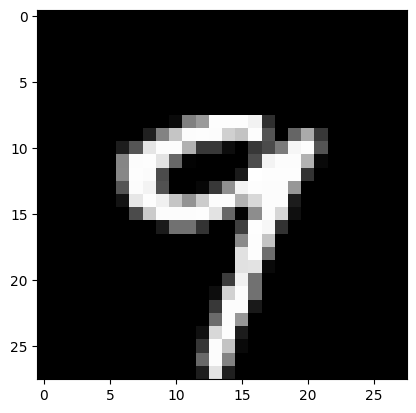

In [5]:
_, testloader = datasets.get_dataset(config_mnist, uniform_dequantization=config_mnist.data.uniform_dequantization, eval_batch_size=1)
sample_img = next(iter(testloader))[0].to(device)
sample_img = repeat(sample_img, 'b c h w -> (b K) c h w', K=config_mnist.model.K)
plt.imshow(sample_img[0, 0].cpu().numpy(), cmap='gray')

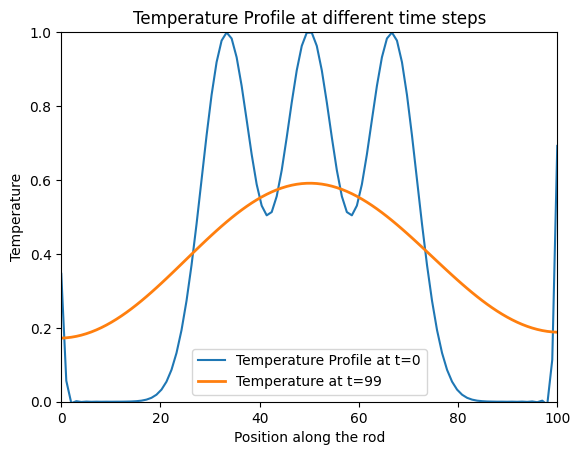

In [6]:
temp_across_timesteps = heat_forward_module_1D(repeat(tri_modal_temp_spaced, 'd -> N d', N=config_mnist.model.K), fwd_steps)
animate_rod_temperature(x, temp_across_timesteps)

We can notice in the animation above, that the derivatives at the edges of the rod gradually go towards zero because of the homogeneous Neumann boundary conditions, and the temperature distribution becomes more and more uniform (diffused) over time. This is because the heat equation is a diffusion equation, and it diffuses the heat from the center to the edges of the rod. This is also the reason why the heat equation is used in image processing for blurring images as we see in the next animation.

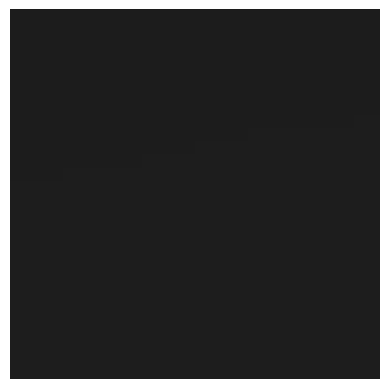

In [7]:
blurred_image_across_timesteps = heat_forward_module_2D_mnist(sample_img, fwd_steps)
blurred_image_across_timesteps = blurred_image_across_timesteps.cpu().numpy()
animate_image_blurring(blurred_image_across_timesteps)

The final image at t=100 is a uniform gray image, which is the steady state solution of the heat equation. The average gray value of the final image is the same as the initial image.
The evolution above follows the 2D heat equation:


$$
\frac{\partial u}{\partial t} = \alpha \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial x^2} \right) 
$$

whose general solution is given by:

$$
u(x, y, t) = \sum_{n=0}^{\infty} \sum_{m=0}^{\infty} B_{n,m} \cos \left( \frac{n \pi x}{L} \right) \cos \left( \frac{m \pi y}{L} \right) \exp \left( -\alpha \left( \frac{n^2 + m^2}{L^2} \right) t \right)
$$

The Fourier domain solution is the same as the 1D case, the dimension of the matrices are only different.

### Train a class-conditional model on MNIST

In [8]:
from models.ema import ExponentialMovingAverage


workdir = "runs/mnist/conditional_1" # directory for saving checkpoints and evaluation outputs

In [ ]:
# Create directory for saving intermediate samples
sample_dir = os.path.join(workdir, "samples")
Path(sample_dir).mkdir(parents=True, exist_ok=True)

# create wandb project
run = wandb.init(project="ihdm-talktorial", entity="mvp18", name="mnist_class_cond", dir=workdir)
run.name = run.name + f'-{run.id}'
assert run is wandb.run

model = utils.create_model(config_mnist, device)
optimizer = utils.get_optimizer(config_mnist, model.parameters())

ema = ExponentialMovingAverage(model.parameters(), decay=config_mnist.model.ema_rate)
state = dict(optimizer=optimizer, model=model, step=0, ema=ema)
model_evaluation_fn = utils.get_model_fn(model, train=False)

# Create checkpoints directory
checkpoint_dir = os.path.join(workdir, "checkpoints")
# Intermediate checkpoints to resume training
checkpoint_meta_dir = os.path.join(workdir, "checkpoints-meta", "checkpoint.pth")
Path(checkpoint_dir).mkdir(parents=True, exist_ok=True)
Path(os.path.dirname(checkpoint_meta_dir)).mkdir(parents=True, exist_ok=True)
# Resume training when intermediate checkpoints are detected
state = utils.restore_checkpoint(checkpoint_meta_dir, state, device)
initial_step = int(state['step'])

# Build data iterators
trainloader, testloader = datasets.get_dataset(config_mnist, uniform_dequantization=config_mnist.data.uniform_dequantization)
train_iter = iter(trainloader)
eval_iter = iter(testloader)

Implementation of the training algorithm

<img src="media/algo1.png" alt="Training Algorithm" title="Training Algorithm" width="700" height="400"/>

In [9]:
def get_inverse_heat_loss_fn(config, train, heat_forward_module):

    sigma = config.model.sigma
    label_sampling_fn = losses.get_label_sampling_function(config.model.K)

    def loss_fn(model, x, y):
        model_fn = utils.get_model_fn(model, train=train)  # get train/eval model
        fwd_steps = label_sampling_fn(x.shape[0], x.device)
        blurred_batch = heat_forward_module(x, fwd_steps).float()
        less_blurred_batch = heat_forward_module(x, fwd_steps-1).float()
        noise = torch.randn_like(blurred_batch) * sigma
        perturbed_data = noise + blurred_batch
        diff = model_fn(perturbed_data, fwd_steps, y)
        prediction = perturbed_data + diff
        losses = (less_blurred_batch - prediction)**2
        losses = torch.sum(losses.reshape(losses.shape[0], -1), dim=-1)
        loss = torch.mean(losses)
        return loss, losses, fwd_steps

    return loss_fn

# Get the forward process definition
loss_fn_train = get_inverse_heat_loss_fn(config_mnist, train=True, heat_forward_module=heat_forward_module_2D_mnist)
loss_fn_eval = get_inverse_heat_loss_fn(config_mnist, train=False, heat_forward_module=heat_forward_module_2D_mnist)

In [10]:
# Build one-step training and evaluation functions
optimize_fn = losses.optimization_manager(config_mnist)

# Get the loss function
train_step_fn = losses.get_step_fn(train=True, config=config_mnist, loss_fn=loss_fn_train, optimize_fn=optimize_fn)
eval_step_fn = losses.get_step_fn(train=False, config=config_mnist, loss_fn=loss_fn_eval, optimize_fn=optimize_fn)

##### Sampling Utilities

Implementation of the sampling algorithm

<img src="media/algo2.png" alt="Sampling Algorithm" title="Sampling Algorithm" width="700" height="400"/>

In [11]:
def get_initial_sample(config, forward_heat_module, device, batch_size=None):
    """Take a draw from the prior p(u_K)"""
    trainloader, _ = datasets.get_dataset(config_mnist, uniform_dequantization=config_mnist.data.uniform_dequantization, train_batch_size=batch_size)

    initial_sample = next(iter(trainloader))
    initial_images = initial_sample[0].to(device)
    original_class = initial_sample[1].to(device) if config_mnist.data.num_classes is not None else None
    initial_sample = forward_heat_module(initial_images, config_mnist.model.K * torch.ones(initial_images.shape[0], dtype=torch.long).to(device))
    return initial_sample, original_class


def get_sampling_fn_inverse_heat(config, initial_sample, initial_class, intermediate_sample_indices, delta, device, share_noise=False):
    """ Returns our inverse heat process sampling function. 
    Arguments: 
    initial_sample: Pytorch Tensor with the initial draw from the prior p(u_K)
    intermediate_sample_indices: list of indices to save (e.g., [0,1,2,3...] or [0,2,4,...])
    delta: Standard deviation of the sampling noise
    share_noise: Whether to use the same noises for all elements in the batch
    """
    K = config.model.K

    def sampler(model):

        if share_noise:
            noises = [torch.randn_like(initial_sample[0], dtype=torch.float)[None] for i in range(K)]
        
        intermediate_samples_out = []

        with torch.no_grad():
            u = initial_sample.to(device).float()
            if intermediate_sample_indices != None and K in intermediate_sample_indices:
                intermediate_samples_out.append((u, u))
            for i in range(K, 0, -1):
                vec_fwd_steps = torch.ones(initial_sample.shape[0], device=device, dtype=torch.long) * i
                # Predict less blurry mean
                u_mean = model(u, vec_fwd_steps, initial_class) + u
                # Sampling step
                if share_noise:
                    noise = noises[i-1]
                else:
                    noise = torch.randn_like(u)
                
                u = u_mean + noise*delta
                # Save trajectory
                if intermediate_sample_indices != None and i-1 in intermediate_sample_indices:
                    intermediate_samples_out.append((u, u_mean))

            return u_mean, [u for (u, u_mean) in intermediate_samples_out]
    
    return sampler

In [12]:
delta = config_mnist.model.sigma * 1.25
# Building sampling functions
initial_sample, initial_class = get_initial_sample(config_mnist, heat_forward_module_2D_mnist, device)
sampling_fn = get_sampling_fn_inverse_heat(config_mnist, initial_sample, initial_class, intermediate_sample_indices=list(range(config_mnist.model.K+1)), delta=delta, device=device)

##### Training loop 

In [ ]:
num_train_steps = config_mnist.training.n_iters

for step in range(initial_step, num_train_steps + 1):
        # Train step
        try:
            batch = next(train_iter)
        except StopIteration:  # Start new epoch if run out of data
            train_iter = iter(trainloader)
            batch = next(train_iter)

        x = batch[0].to(device).float()
        y = batch[1].to(device) if config_mnist.data.num_classes is not None else None
        loss, losses_batch, fwd_steps_batch = train_step_fn(state, x, y)

        wandb.log({"training_loss": loss.item()}, step)

        # Save a temporary checkpoint to resume training if training is stopped
        if step != 0 and step % config_mnist.training.snapshot_freq_for_preemption == 0:
            ("Saving temporary checkpoint")
            utils.save_checkpoint(checkpoint_meta_dir, state)

        # Report the loss on an evaluation dataset periodically
        if step % config_mnist.training.eval_freq == 0:
            print("Starting evaluation")
            # Use 25 batches for test-set evaluation, arbitrary choice
            N_evals = 25
            for i in range(N_evals):
                try:
                    eval_batch = next(eval_iter)
                except StopIteration:  # Start new epoch
                    eval_iter = iter(testloader)
                    eval_batch = next(eval_iter)

                x_eval = eval_batch[0].to(device).float()
                y_eval = eval_batch[1].to(device) if config_mnist.data.num_classes is not None else None
                eval_loss, losses_batch, fwd_steps_batch = eval_step_fn(state, x_eval, y_eval)
                eval_loss = eval_loss.detach()
                wandb.log({"eval_loss": eval_loss.item()}, step)
            print(f"step: {step}, eval_loss: {eval_loss.item()}")

        # Save a checkpoint periodically
        if step != 0 and step % config_mnist.training.snapshot_freq == 0 or step == num_train_steps:
            print("Saving a checkpoint")
            # Save the checkpoint.
            save_step = step // config_mnist.training.snapshot_freq
            utils.save_checkpoint(pjoin(checkpoint_dir, 'checkpoint_{}.pth'.format(save_step)), state)

        # Generate samples periodically
        if step != 0 and step % config_mnist.training.sampling_freq == 0 or step == num_train_steps:
            print("Sampling...")
            ema.store(model.parameters())
            ema.copy_to(model.parameters())
            sample, intermediate_samples = sampling_fn(model_evaluation_fn)
            ema.restore(model.parameters())
            this_sample_dir = pjoin(sample_dir, "iter_{}".format(step))
            Path(this_sample_dir).mkdir(parents=True, exist_ok=True)
            # utils.save_tensor(this_sample_dir, sample, "final.np")
            utils.save_png(this_sample_dir, sample, "final.png")
            if initial_sample != None: utils.save_png(this_sample_dir, initial_sample, "init.png")
            # utils.save_gif(this_sample_dir, intermediate_samples)
            utils.save_video(this_sample_dir, intermediate_samples)

### Sampling using a Trained Checkpoint

In [13]:
workdir = "runs/mnist/conditional"

In [14]:
delta = config_mnist.model.sigma * 1.25
intermediate_sample_indices = list(range(config_mnist.model.K+1))

# Directory name for saving results
sample_dir = pjoin(workdir, "additional_samples")
this_sample_dir = pjoin(sample_dir, "checkpoint_0")
this_sample_dir = os.path.join(this_sample_dir, "delta_{}".format(delta))

sample_batch_size = 9
delta = config_mnist.model.sigma * 1.25 # The standard deviation of noise to add at each step with predicted reverse blur

checkpoint_dir = os.path.join(workdir, "checkpoints-meta")
model = utils.load_model_from_checkpoint_dir(config_mnist, checkpoint_dir, device)
model_fn = utils.get_model_fn(model, train=False)
print(f"Loaded model from {checkpoint_dir} running on {device}")

Loaded model from runs/mnist/conditional/checkpoints-meta running on cuda:0


In [15]:
def sample(config, heat_forward_module, intermediate_sample_indices, batch_size, same_init_u=False, same_init_class=False, share_noise=False, save_dir=None):
    
    initial_sample, initial_class = get_initial_sample(config, heat_forward_module, device, batch_size=batch_size)
    initial_sample = initial_sample[:sample_batch_size]

    if same_init_u:
        initial_sample = torch.cat(sample_batch_size * [initial_sample[0][None]], 0)
        save_dir += "_same_init"
    if same_init_class:
        initial_class = torch.cat(sample_batch_size * [initial_class[0][None]], 0)
        save_dir += "_same_class"
    if share_noise:
        save_dir += "_share_noise"

    Path(save_dir).mkdir(parents=True, exist_ok=True)
    sampling_fn = get_sampling_fn_inverse_heat(config, initial_sample, initial_class, intermediate_sample_indices, delta, device, share_noise=True)
    sample, intermediate_samples = sampling_fn(model_fn)

    utils.save_png(save_dir, sample, "final.png")
    utils.save_png(save_dir, initial_sample, "init.png")
    utils.save_video(save_dir, intermediate_samples)

    print(f"Sample classes: {initial_class}")
    print(f"Output sample saved at {save_dir}")
    return Image(pjoin(save_dir, "final.png"))

##### Same prior initialization

Sample classes: tensor([0, 1, 1, 1, 1, 2, 6, 0, 9], device='cuda:0')
Output sample saved at runs/mnist/conditional/additional_samples/checkpoint_0/delta_0.0125_same_init


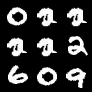

In [16]:
same_init_u = True
same_init_class = False
share_noise = False

sample(config_mnist, heat_forward_module_2D_mnist, intermediate_sample_indices, sample_batch_size, same_init_u, same_init_class, share_noise, this_sample_dir)

##### Same class conditioning signal for all samples

Sample classes: tensor([3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
Output sample saved at runs/mnist/conditional/additional_samples/checkpoint_0/delta_0.0125_same_class


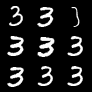

In [17]:
same_init_u = False
same_init_class = True
share_noise = False

sample(config_mnist, heat_forward_module_2D_mnist, intermediate_sample_indices, sample_batch_size, same_init_u, same_init_class, share_noise, this_sample_dir)

##### Same prior and same class signal

Sample classes: tensor([3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
Output sample saved at runs/mnist/conditional/additional_samples/checkpoint_0/delta_0.0125_same_init_same_class


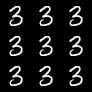

In [20]:
same_init_u = True
same_init_class = True
share_noise = False

sample(config_mnist, heat_forward_module_2D_mnist, intermediate_sample_indices, sample_batch_size, same_init_u, same_init_class, share_noise, this_sample_dir)

##### Sharing noise between consecutive deblurring timesteps in Algorithm 2

Sample classes: tensor([7, 2, 6, 2, 8, 8, 4, 1, 9], device='cuda:0')
Output sample saved at runs/mnist/conditional/additional_samples/checkpoint_0/delta_0.0125_share_noise


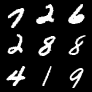

In [18]:
same_init_u = False
same_init_class = False
share_noise = True

sample(config_mnist, heat_forward_module_2D_mnist, intermediate_sample_indices, sample_batch_size, same_init_u, same_init_class, share_noise, this_sample_dir)

##### Same prior initialization and sharing noise

Sample classes: tensor([4, 9, 2, 9, 8, 4, 2, 0, 5], device='cuda:0')
Output sample saved at runs/mnist/conditional/additional_samples/checkpoint_0/delta_0.0125_same_init_share_noise


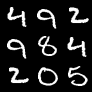

In [19]:
same_init_u = True
same_init_class = False
share_noise = True

sample(config_mnist, heat_forward_module_2D_mnist, intermediate_sample_indices, sample_batch_size, same_init_u, same_init_class, share_noise, this_sample_dir)

### Conclusion:

What we can observe from the above results, is sharing noise leads to sharper results, and class conditioning leads to more class-specific results. Without noise sharing, however, results can be a bit ambiguous. For example, with just the same prior initization as in the first experiment, a class signal of '1' leads to a hybrid digit that looks somewhere between 1 and 2. On the other hand, sharing just the same class signal across different priors, leads to slightly varied images of the same class. The images look a lot more sharper when the initial prior is also the same, but the cost of almost zero diversity.